In [21]:
import pandas as pd
import hashlib
import pandahouse
import seaborn as sns
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot
sns.set(rc = {'figure.figsize' : (12,6)})

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20240120'
}

# Задание 3

Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше по сравнению с обычным CTR?

Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше по сравнению с обычным CTR?

Данные берём в том же диапазоне, в котором проводился АБ-тест. При выполнении задания также важно обосновать и аргументировать ваши ответы и выводы.

### Сделаем запрос к базе для получения распределения лайков, просмотров и CTR для групп 0 и 3

In [36]:
q = """
select exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes / views as ctr
from {db}.feed_actions
where toDate(time) between '2023-12-29' and '2024-01-04'
    and exp_group in (0,3)
    group by exp_group, user_id
"""
df = pandahouse.read_clickhouse(q, connection = connection)

### Считаем общий CTR в контрольной группе

In [37]:
CTRcontrol = df[df.exp_group == 0].likes.sum() / df[df.exp_group == 3].views.sum()

In [38]:
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,12,44,0.272727
1,3,123580,2,11,0.181818
2,0,4944,8,41,0.195122
3,0,4504,5,15,0.333333
4,0,121508,6,25,0.240000


In [39]:
CTRcontrol

0.2103426884412721

### Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠

In [40]:
df['linearized_likes'] = df.likes - CTRcontrol*df.views

### Посмотрим как выглядит распределение метрики

<Axes: xlabel='linearized_likes', ylabel='Count'>

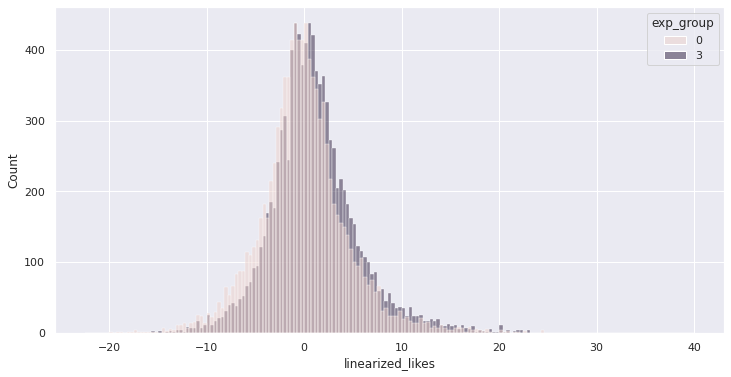

In [41]:
sns.histplot(data = df, x = 'linearized_likes',hue = 'exp_group')

### сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠

In [42]:
ss.ttest_ind(df[df.exp_group == 0].linearized_likes,df[df.exp_group == 3].linearized_likes,equal_var = False)

Ttest_indResult(statistic=-16.185111817476212, pvalue=1.5188399261487063e-58)

In [44]:
ss.ttest_ind(df[df.exp_group == 0].ctr,df[df.exp_group == 3].ctr,equal_var = False)

Ttest_indResult(statistic=-13.935320516755773, pvalue=6.216047483062228e-44)

### т-тест показывает  статически значимые различия между группами. P-value стало меньше для метрики linearized likes


### Проделаем те же операции для групп 1 и 2

In [45]:
q = """
select exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes / views as ctr
from {db}.feed_actions
where toDate(time) between '2023-12-29' and '2024-01-04'
    and exp_group in (1,2)
    group by exp_group, user_id
"""
df2 = pandahouse.read_clickhouse(q, connection = connection)

In [46]:
CTRcontrol = df2[df2.exp_group == 1].likes.sum() / df2[df2.exp_group == 2].views.sum()

In [47]:
df2['linearized_likes'] = df2.likes - CTRcontrol*df2.views

<Axes: xlabel='linearized_likes', ylabel='Count'>

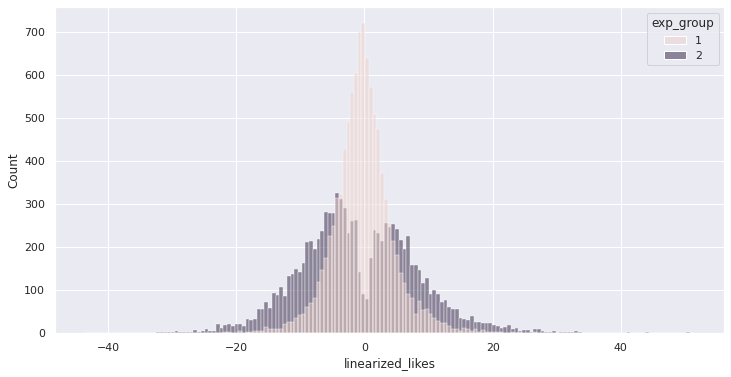

In [48]:
sns.histplot(data = df2, x = 'linearized_likes',hue = 'exp_group')

In [51]:
ss.ttest_ind(df2[df2.exp_group == 1].linearized_likes,df2[df2.exp_group == 2].linearized_likes,equal_var = False)

Ttest_indResult(statistic=5.911547801865759, pvalue=3.4651949397662443e-09)

In [52]:
ss.ttest_ind(df2[df2.exp_group == 1].ctr,df2[df2.exp_group == 2].ctr,equal_var = False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

### В этом случае т-тест видит статиcтически значимые различия между группами. В отличие от теста проведенного для метрики CTR,p-value стало меньше порога статистической значимости
